In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
import random

from glob import glob
import cv2
from pathlib import Path
import os
from sklearn.metrics import classification_report

In [13]:
train_df = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv')
train_annot = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv')

from pathlib import Path

path = Path('/projects/sc73/ranzcr-clip-catheter-line-classification/train')

def add_path(row):

    row['image_path'] = str(path / (row['StudyInstanceUID'] + '.jpg'))
    return row

train_df = train_df.apply(add_path, axis=1)

In [14]:
columns_to_check = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged',
    'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline',
    'CVC - Normal', 'Swan Ganz Catheter Present'
]

train_df = train_df[~train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

train_df = train_df[train_df['NGT - Incompletely Imaged'] == 0]
train_df = train_df.drop(columns=['NGT - Incompletely Imaged'])

train_df = train_df[train_df['Swan Ganz Catheter Present'] == 0]
train_df = train_df.drop(columns=['Swan Ganz Catheter Present'])
train_df.shape

(26752, 12)

In [16]:
ids =  train_annot['StudyInstanceUID'].unique()

train_df_annot = train_df[train_df['StudyInstanceUID'].isin(ids)]
train_df_annot

def update_path(row):
    row['image_path'] = f'/fs03/sc73/Shekinah Robins/train_imgs/{row["StudyInstanceUID"]}.jpg'
    return row

train_df_annot = train_df_annot.apply(update_path, axis=1).reset_index(drop=True)

train_df_annot.shape

(7971, 12)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import resample

In [19]:
tube_classifying= train_df_annot.copy()

tube_classifying['CVC_placement'] = tube_classifying[['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']].values.tolist()

ct_id = tube_classifying['StudyInstanceUID'].unique()
test_data = train_df[~train_df['StudyInstanceUID'].isin(ct_id)].copy() 
test_data['CVC_placement'] = test_data[['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']].values.tolist()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class CustomDataset(Dataset):
    def __init__(self, dataframe, x_col, y_col, transform=None):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx][self.x_col]
        image = Image.open(img_path).convert('RGB')  
        label = float(self.dataframe.iloc[idx][self.y_col])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

class ResNet50Binary(nn.Module):
    def __init__(self, num_classes=1, freeze_layers=True):
        super(ResNet50Binary, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        
        # Replace the fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),          # Dropout layer for regularization
            nn.Linear(in_features, 256),  # First hidden layer
            nn.ReLU(),                # ReLU activation after first hidden layer
            nn.Dropout(0.3),          # Additional Dropout layer
            nn.Linear(256, num_classes)  # Output layer
        )

    def forward(self, x):
        return torch.sigmoid(self.resnet(x))  # Sigmoid on the final output

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, 
                checkpoint_path="res_CVC2.pth", patience=5, min_delta=0.001):
    history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == labels.unsqueeze(1)).sum().item()
            train_total += labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        history['accuracy'].append(train_acc)
        history['loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))

                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels.unsqueeze(1)).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save the best model
        if val_acc - best_val_accuracy > min_delta:
            best_val_accuracy = val_acc
            best_model_state_dict = model.state_dict()
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved with validation accuracy: {val_acc:.4f}")
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break

    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
        print("Restored best model weights")

    return history, model

def visualize_training(history, image_type, save_path):
    
    acc_min = min(min(history['accuracy']), min(history['val_accuracy'])) - 0.005
    acc_max = max(max(history['accuracy']), max(history['val_accuracy'])) + 0.005
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history['accuracy'], label='Training Accuracy', color='palevioletred')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='cornflowerblue')
    plt.ylim([acc_min, acc_max]) 
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.title(f'Training and Validation Accuracy - ResNet50 {image_type}', fontweight='bold')
    
    loss_min = min(min(history['loss']), min(history['val_loss'])) - 0.005
    loss_max = max(max(history['loss']), max(history['val_loss'])) + 0.005
    
    plt.subplot(2, 1, 2)
    plt.plot(history['loss'], label='Training Loss', color='palevioletred')
    plt.plot(history['val_loss'], label='Validation Loss', color='cornflowerblue')
    plt.ylim([loss_min, loss_max])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Training and Validation Loss - ResNet50 {image_type}', fontweight='bold')
    plt.grid()
    plt.xlabel('epoch')

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def evaluate_model(model, test_loader, device, class_names, image_type):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'ResNet50 {image_type} Confusion Matrix')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.savefig(f'conf_matrix_res_{image_type}3.png', dpi=300, bbox_inches='tight')
    plt.close()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    with open(f'classification_res_{image_type}3.txt', 'w') as f:
        f.write(report)

    return y_true, y_pred

def main(image_type, train_df_annot, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])  
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])   
    ])

    full_dataset = CustomDataset(train_df_annot, 'image_path', image_type, transform=train_transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    test_dataset = CustomDataset(test_data, 'image_path', image_type, transform=val_test_transform)

    val_dataset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = ResNet50Binary().to(device)
    criterion = nn.BCELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history, model = train_model(model, train_loader, val_loader, criterion, optimizer, device,
                                 num_epochs=10, checkpoint_path=f"res_{image_type}3.pth")

    visualize_training(history, image_type, f'training_curve_res_{image_type}3.png')
    evaluate_model(model, test_loader, device, class_names=['Negative', 'Positive'], image_type=image_type)

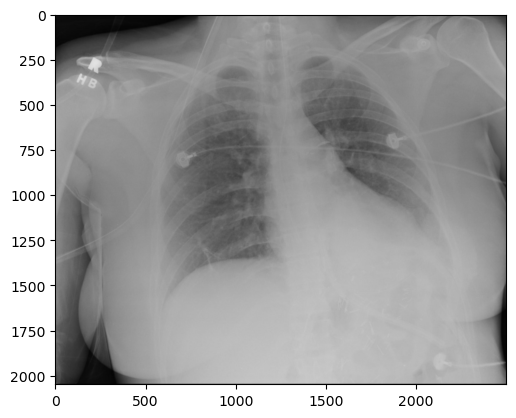

In [21]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
path = test_data['image_path'][0]       
img = get_image(path)
plt.imshow(img)

In [23]:
def get_input_transform():
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])   
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

def load_model(model_class, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path), strict=False)
    model.eval() 
    return model

def predict(model, img_tensor, device, threshold=0.5):

    with torch.no_grad():  
        model.to(device)  
        output = model(img_tensor.to(device)) 
        return 1 if output >= threshold else 0

